Christian H. Bye

Data challenge, sim3.npz (bowtie antenna). The challenge assumes a rotating antenna. Each timestep, the antenna goes through a full 2pi sweep in az and alt. A transmitter antenna is transmitting a Dirac comb for every 16th frequency channel; it's flat in ampltiude with no spectral leakage.

In [11]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import healpy as hp
from astropy.time import Time
import hera_filters

%matplotlib widget

In [2]:
d = np.load("sim_v003.npz")
for k, v in d.items():
    print(k, v.shape)

freqs = d["freqs"] / 1e6  # mhz
az, alt = d["azalts"].T
data = d["data"]
times = d["times"]  # jd
tx_crds = d["tx_crds_topo"][:, 0]
tx_flux = d["tx_flux"][0]

# az and alt both go 0-2pi which is unneccsary
#data = data[:, alt <= np.pi]
#az = az[alt <= np.pi]
#alt = alt[alt <= np.pi]

# remove the last time which would mess up time averages (double counting since first == last)
print(f"Duration in JD: {times[-1] - times[0]}")
data = data[:-1]
times = times[:-1]

# mask transmitter channels
tx_freq = freqs[::16]
tx_mask = np.zeros(data.shape, dtype=bool)
tx_mask[:, :, ::16] = True
print(tx_freq)
data = np.ma.array(data, mask=tx_mask)
tx_mask_1d = tx_mask[0, 0]

freqs (1024,)
data (144, 1296, 1024)
azalts (1296, 2)
times (144,)
tx_crds_topo (3, 1)
tx_flux (1, 1024)
Duration in JD: 1.0
[ 50.          53.12805474  56.25610948  59.38416422  62.51221896
  65.6402737   68.76832845  71.89638319  75.02443793  78.15249267
  81.28054741  84.40860215  87.53665689  90.66471163  93.79276637
  96.92082111 100.04887586 103.1769306  106.30498534 109.43304008
 112.56109482 115.68914956 118.8172043  121.94525904 125.07331378
 128.20136852 131.32942326 134.45747801 137.58553275 140.71358749
 143.84164223 146.96969697 150.09775171 153.22580645 156.35386119
 159.48191593 162.60997067 165.73802542 168.86608016 171.9941349
 175.12218964 178.25024438 181.37829912 184.50635386 187.6344086
 190.76246334 193.89051808 197.01857283 200.14662757 203.27468231
 206.40273705 209.53079179 212.65884653 215.78690127 218.91495601
 222.04301075 225.17106549 228.29912023 231.42717498 234.55522972
 237.68328446 240.8113392  243.93939394 247.06744868]


In [3]:
tstart, tstop = Time([times[0], times[-1]], format="jd").to_datetime()
print(tstart, tstop)
extent = [freqs[0], freqs[-1], tstop, tstart]

def waterfall(data, log=False, vmin=None, vmax=None, aspect="auto", extent=extent, interpolation="none", cmap="plasma", title=None):
    if log:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    plt.figure()
    plt.imshow(data, aspect=aspect, extent=extent, interpolation=interpolation, cmap=cmap, norm=norm)
    plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

2024-10-17 18:00:00 2024-10-18 17:49:55.804203


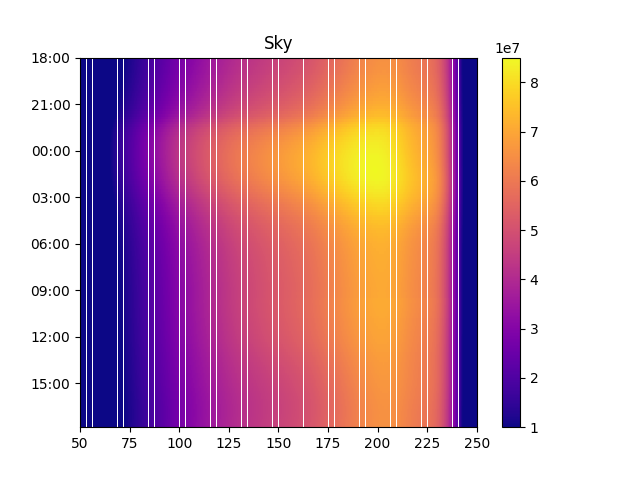

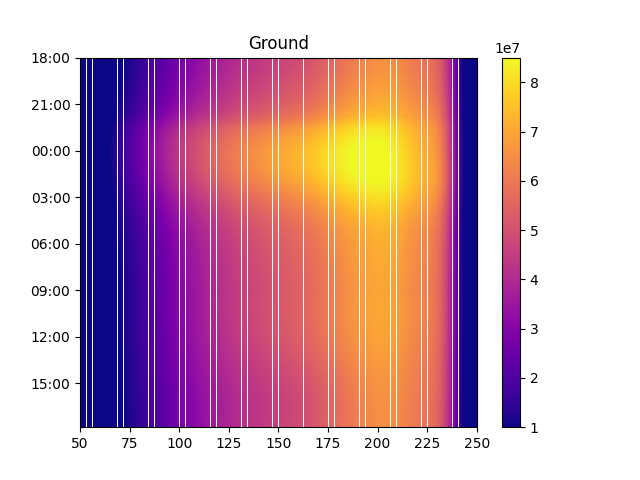

In [4]:
waterfall(data[:, 0], log=False, vmin=1e7, vmax=8.5e7, title="Sky")  # antenna pointing "up"
waterfall(data[:, -18], log=False, vmin=1e7, vmax=8.5e7, title="Ground") # antenna pointing "down"

## Beam Mapping

We fit a DPSS model to the measured data and assume that the residual contribution is the transmitter. We average over time first, which is equivalent to a joint fit at each timestep (when everything is linear).

Note that the value we get is the beam directivity times the bandpass and beam efficiency etc. It captures the full frequency dependence of the instrument. The simulation does not capture the polarization mismatch between the transmitter and the bowtie. It also assumes the bowtie beam is independent of the azimuthal rotations of the antenna.

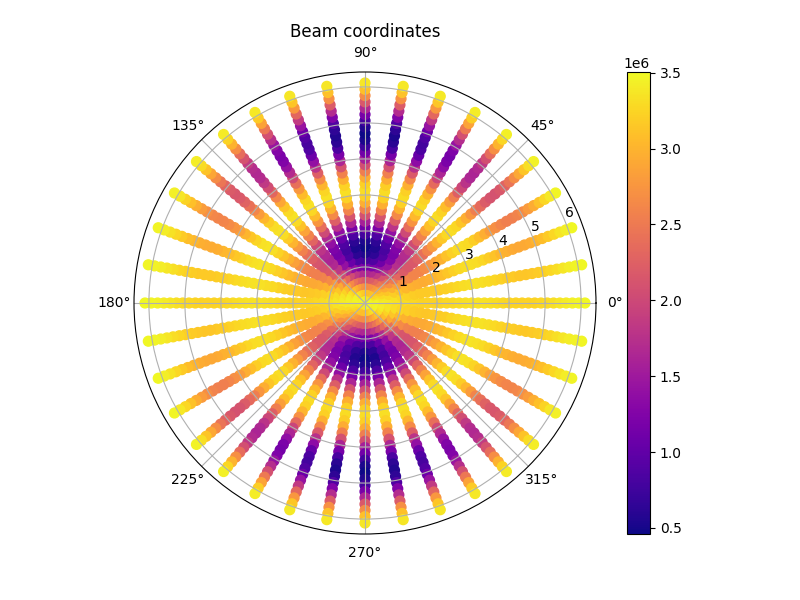

In [5]:
dtavg = data.data.mean(axis=0)  # avg in time, shape: (angle, freq)
tx_data = dtavg[:, ::16] # only tx freqs
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 6))
sc = ax.scatter(az, alt, c=tx_data[..., 0], cmap="plasma", s=50)
plt.colorbar(sc, ax=ax, label="")
ax.set_title("Beam coordinates", pad=25)
plt.show()

In [6]:
# for each rotation, we fit dpss
def fit_dpss_step(freq, spec):
    """
    freq : all frequencies in MHz (len Nfreq)
    spec : time avg data, at one rotation (len Nfreq)

    returns:
    mdl : dpss model for smooth component
    res_smooth : residuals for non-tx freqs only
    res : full residuals
    """
    weights = np.ones_like(spec)
    weights[::16] = 0  # 0 out tx freqs
    filter_half_width = 300e-9  # 300 ns
    freq_Hz = freq * 1e6
    mdl, res_smooth, info = hera_filters.dspec._fit_basis_1d(freq_Hz, spec, weights, [0], [filter_half_width], {"eigenval_cutoff": [1e-12]}, method="matrix", basis="dpss")
    mdl = mdl.real
    res_smooth = res_smooth.real
    res = spec - mdl
    nterms = info["amat"].shape[1]
    chi_sq = np.mean(res_smooth**2) / (freq.size - nterms)
    return mdl, res_smooth, res, chi_sq

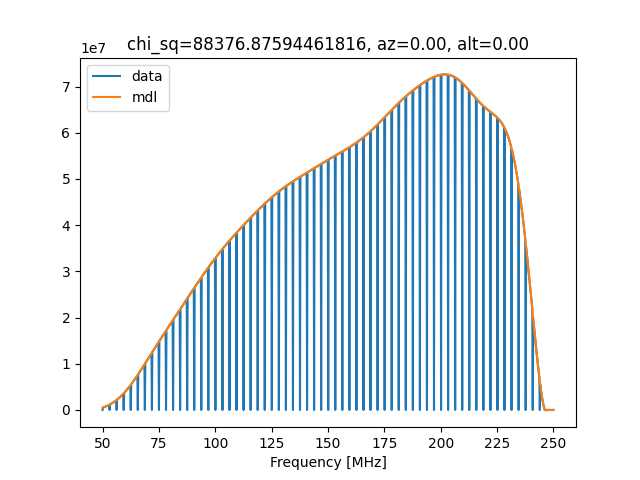

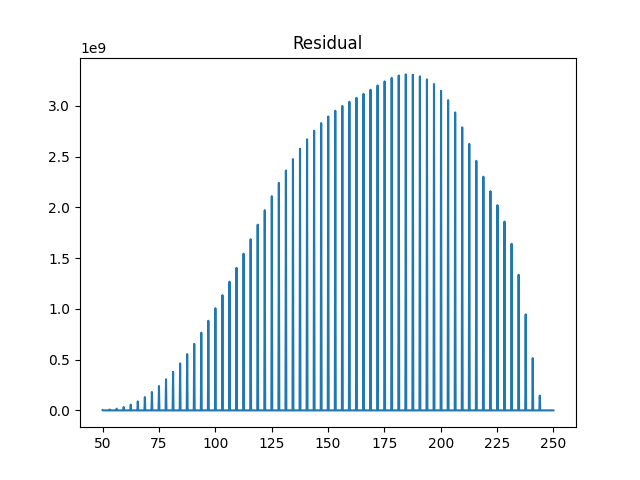

In [7]:
for rix in [0]:
    mdl, res_smooth, res, chi_sq = fit_dpss_step(freqs, dtavg[rix])
    smooth_data = dtavg[rix].copy()
    smooth_data[::16] = 0
    plt.figure()
    plt.plot(freqs, smooth_data, label="data")
    plt.plot(freqs, mdl, label="mdl")
    plt.title(f"{chi_sq=}, az={az[rix]:.2f}, alt={alt[rix]:.2f}")
    plt.legend()
    plt.xlabel("Frequency [MHz]")
    plt.show()
    plt.figure()
    plt.plot(freqs, res)
    plt.title("Residual")
    plt.show()

In [20]:
# fit each position
Nrot = az.size
Nfreq = freqs.size

fname = "tx_meas.npz"
if not Path(fname).exists():
    chi_sq = np.empty(Nrot)
    res = np.empty((Nrot, Nfreq))
    for i in range(az.size):
        mdl, res_smooth, res[i], chi_sq[i] = fit_dpss_step(freqs, dtavg[i])
    np.savez(fname, res=res, chi_sq=chi_sq)
else:
    npz = np.load(fname)
    res = npz["res"]
    chi_sq = npz["chi_sq"]

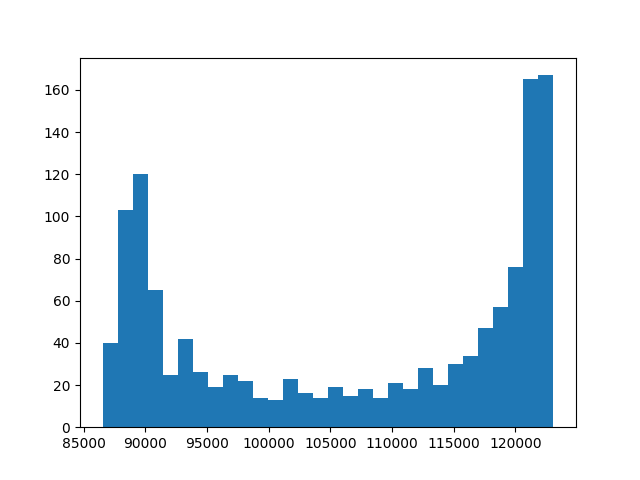

In [21]:
plt.figure()
plt.hist(chi_sq, bins=30)
plt.show()